In [12]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#### read_csv(), shape, head() methods of pandas are used to read the csv dataset file, get the shape and first few(5) rows of dataset respectively. 


In [13]:
data = pd.read_csv('traffic_volume_1hr.csv')

In [14]:
print(data.shape)

(3624, 4)


In [15]:
print(data.head())

   month  day  hr  total_volume
0      1    1   1          1165
1      1    1   2          1306
2      1    1   3           930
3      1    1   4           818
4      1    1   5           675


In [16]:
print(data.tail())

      month  day  hr  total_volume
3619      5   31  20          2990
3620      5   31  21          2168
3621      5   31  22          1515
3622      5   31  23          1326
3623      5   31  24           965


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624 entries, 0 to 3623
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   month         3624 non-null   int64
 1   day           3624 non-null   int64
 2   hr            3624 non-null   int64
 3   total_volume  3624 non-null   int64
dtypes: int64(4)
memory usage: 113.4 KB


In [18]:
data.describe()

,month,day,hr,total_volume
count,3624.000000,3624.000000,3624.000000,3624.000000
mean,3.013245,15.622517,12.500000,1955.531457
std,1.423683,8.752171,6.923142,1033.506698
min,1.000000,1.000000,1.000000,432.000000
25%,2.000000,8.000000,6.750000,921.000000
50%,3.000000,16.000000,12.500000,2005.000000
75%,4.000000,23.000000,18.250000,2854.000000
max,5.000000,31.000000,24.000000,4024.000000


#### First, total_volume column is extracted from data as it is the information upon which the prediction will depend. It is better to convert df into float as later some scaling transformation will be applied. Using reshape() method dataset is shaped to 3624×1. 

In [19]:
df = data['total_volume']
dataset = df.values.astype('float32')
dataset = np.reshape(dataset, (len(dataset),1))

In [20]:
print(dataset.shape)

(3624, 1)


#### Let's see how the traffic_volume varies along with hr- I am plotting the graph for first 7 days of month 5(i.e. may) against hr. To plot total_volume with respect to hr, first make hr as index, then plot. Also group the plot_data by days to get different lines for each seven days. 

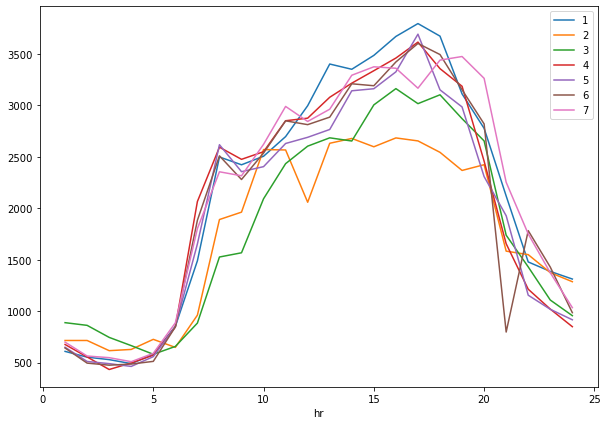

In [21]:
plot_data = data[(data.month == 5) & (data.day <= 7)]
fig, ax = plt.subplots(figsize=(10,7))
plot_data.set_index('hr', inplace=True)
pt = plot_data.groupby('day')['total_volume'].plot(legend=True)

#### Let's star building the traffic forecasting model. 
#### First import all the required Python libraries. 

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


#### LSTM model is very sensitive to the scale of the input data, it is a standard practice to standardize the data to the range of 0 to 1. sklearn.preprocessing module has MinMaxScaler class that helps us standardize the data easily. 

In [23]:
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

#### In classification or regression problem, we usually do this by splitting the dataset randomly into training data and test data. But in time series analysis, the sequence of data is also important. So, initial 70% of the dataset is used for training and rest 30% for testing purpose. 

In [24]:
train_size=int(len(dataset)*.7)
test_size=len(dataset)-train_size

In [25]:
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]


In [26]:
print(train_size)

2536


In [27]:
print(test_size)

1088


In [28]:
train

array([[0.20406458],
       [0.2433185 ],
       [0.13864142],
       ...,
       [0.9334632 ],
       [0.9095212 ],
       [0.92761695]], dtype=float32)

In [29]:
print(train.shape)

(2536, 1)


In [30]:
test


array([[1.        ],
       [0.9111916 ],
       [0.86330736],
       ...,
       [0.30150333],
       [0.2488864 ],
       [0.14838529]], dtype=float32)

In [31]:
print(test.shape)

(1088, 1)


#### Before start building the model, first have to divide the training and testing data into independent(X) and dependent data(Y). In this problem both independent and dependent data is total_volume which is stored in dataset variable. traffic_volume of present hr is the output, predicted by the traffic_volume of some previous hours as inputs. The count of observations considered as input to predict the output is called timesteps. Here, 24 timesteps(lookback) is selected. Means, there is need of 24 traffic_volume to predict the traffic_volume of 25th hour. The value of timestep is selected by trying different values for it and then best suited value is choosed. 

In [32]:
def transform_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        a=dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)        

In [33]:
look_back=24
trainX,trainY=transform_dataset(train,look_back)
testX,testY=transform_dataset(test,look_back)

In [34]:
trainX


array([[0.20406458, 0.2433185 , 0.13864142, ..., 0.2346882 , 0.18569043,
        0.13836303],
       [0.2433185 , 0.13864142, 0.10746103, ..., 0.18569043, 0.13836303,
        0.07795101],
       [0.13864142, 0.10746103, 0.06765034, ..., 0.13836303, 0.07795101,
        0.04732739],
       ...,
       [0.75974387, 0.7586303 , 0.8296214 , ..., 0.63001114, 0.6703786 ,
        0.74693763],
       [0.7586303 , 0.8296214 , 0.88390875, ..., 0.6703786 , 0.74693763,
        0.8346325 ],
       [0.8296214 , 0.88390875, 0.9323497 , ..., 0.74693763, 0.8346325 ,
        0.9334632 ]], dtype=float32)

In [35]:
trainY

array([0.07795101, 0.04732739, 0.02923163, ..., 0.8346325 , 0.9334632 ,
       0.9095212 ], dtype=float32)

In [36]:
print(trainX.shape)

(2511, 24)


In [37]:
print(trainY.shape)

(2511,)


In [38]:
print(testX.shape)

(1063, 24)


#### Now the RNN takes 3D input as (batch_size, timesteps, input_dim). So, We have to convert the trainX and testX into required dimensions. 

In [39]:
trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1))

In [40]:
print(trainX.shape)
print(testX.shape)

(2511, 24, 1)
(1063, 24, 1)


#### We are going to stochastic gradient descent optimizer. For that use the SGD and fix the learning rate as 0.1.


#### Define a sequential model with 2 layers as LSTM and Dense. Second layer is the last layer which is the output layer also.  After compiling the model with mean squared error, fit it with 10 epochs and 1 batch size. After compiling the model with mean squared error, fit it with 10 epochs and 1 batch size. 

In [41]:
sgd=SGD(lr=0.1)
model=Sequential()
model.add(LSTM(1,input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer=sgd)
model.fit(trainX,trainY,epochs=10,batch_size=1,verbose=2)

Epoch 1/10
 - 14s - loss: 0.0228
Epoch 2/10
 - 13s - loss: 0.0095
Epoch 3/10
 - 13s - loss: 0.0091
Epoch 4/10
 - 14s - loss: 0.0088
Epoch 5/10
 - 13s - loss: 0.0088
Epoch 6/10
 - 13s - loss: 0.0086
Epoch 7/10
 - 14s - loss: 0.0083
Epoch 8/10
 - 13s - loss: 0.0072
Epoch 9/10
 - 13s - loss: 0.0068
Epoch 10/10
 - 13s - loss: 0.0068


#### Initially, the whole dataset was transformed to between 0 and 1, to get the initial values back use inverse transform function. 

In [42]:
trainPredict=model.predict(trainX)
testPredict=model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [43]:
print(testPredict.shape)
print(trainPredict.shape)
print(testY.shape)
print(trainY.shape)

(1063, 1)
(2511, 1)
(1, 1063)
(1, 2511)


#### Now plot the actual values and the predicted values on a chart. 

In [44]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [45]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

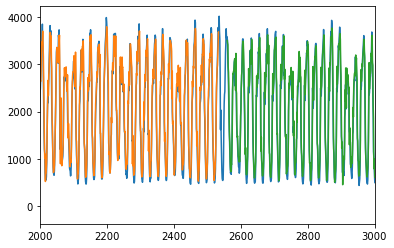

In [46]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(2000, 3000)
plt.show()
